In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import random
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from skimage import color
from skimage.transform import resize
from skimage.filters import threshold_otsu, gaussian
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
model_save_dir = r"/content/drive/MyDrive/100_prj/saved_models"

try:
    os.mkdir(model_save_dir)
except:
    pass

In [5]:
# Set the path to your dataset
dataset_path = r"/content/drive/MyDrive/100_prj/ECG_IMAGES_DATASET"

num_classes = len(os.listdir(dataset_path))
# Define image size and other parameters

# Example parameters
input_shape = (512, 512, 3)
num_classes = 4
batch_size = 32

# Create an ImageDataGenerator for data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split the data into training and validation sets
)

# Generate training dataset
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Generate validation dataset
validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

def plot_hist(model):
    history = model.history
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()




Found 745 images belonging to 4 classes.
Found 183 images belonging to 4 classes.


## LeNet 5

In [7]:
# Define LeNet-5 model
lenet = models.Sequential()
lenet.add(layers.Conv2D(6, (5, 5), activation='relu', input_shape=input_shape))
lenet.add(layers.MaxPooling2D((2, 2)))
lenet.add(layers.Conv2D(16, (5, 5), activation='relu'))
lenet.add(layers.MaxPooling2D((2, 2)))
lenet.add(layers.Flatten())
lenet.add(layers.Dense(120, activation='relu'))
lenet.add(layers.Dense(84, activation='relu'))
lenet.add(layers.Dense(num_classes, activation='softmax'))  # Adjust num_classes based on your dataset

# Compile the model
lenet.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
lenet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 508, 508, 6)       456       
                                                                 
 max_pooling2d (MaxPooling2  (None, 254, 254, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 250, 250, 16)      2416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 125, 125, 16)      0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 250000)            0         
                                                                 
 dense (Dense)               (None, 120)               3

In [12]:
train_generator.class_indices

{'History of MI': 0,
 'Myocardial Infarction': 1,
 'Normal': 2,
 'abnormal heartbeat': 3}

In [8]:
# Train the model
epochs = 10

history = lenet.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

# Save the trained model
lenet_path = f'{model_save_dir}/lenet5_ecg_model.hd5'
lenet.save(lenet_path)

# lenet_loaded_model = tf.keras.saving.load_model(f'{model_save_dir}/lenet5_ecg_model.keras')

Epoch 1/10
24/24 [==============================] - 278s 11s/step - loss: 2.5264 - accuracy: 0.2376 - val_loss: 1.3965 - val_accuracy: 0.2787
Epoch 2/10
24/24 [==============================] - 77s 3s/step - loss: 1.3864 - accuracy: 0.2872 - val_loss: 1.3623 - val_accuracy: 0.3115
Epoch 3/10
24/24 [==============================] - 81s 3s/step - loss: 1.3729 - accuracy: 0.3154 - val_loss: 1.3492 - val_accuracy: 0.3388
Epoch 4/10
24/24 [==============================] - 82s 3s/step - loss: 1.3645 - accuracy: 0.3128 - val_loss: 1.3744 - val_accuracy: 0.3333
Epoch 5/10
24/24 [==============================] - 76s 3s/step - loss: 1.3612 - accuracy: 0.3262 - val_loss: 1.3432 - val_accuracy: 0.4098
Epoch 6/10
24/24 [==============================] - 78s 3s/step - loss: 1.3554 - accuracy: 0.3409 - val_loss: 1.3450 - val_accuracy: 0.3443
Epoch 7/10
24/24 [==============================] - 77s 3s/step - loss: 1.3365 - accuracy: 0.3758 - val_loss: 1.2764 - val_accuracy: 0.4044
Epoch 8/10
24/24 [

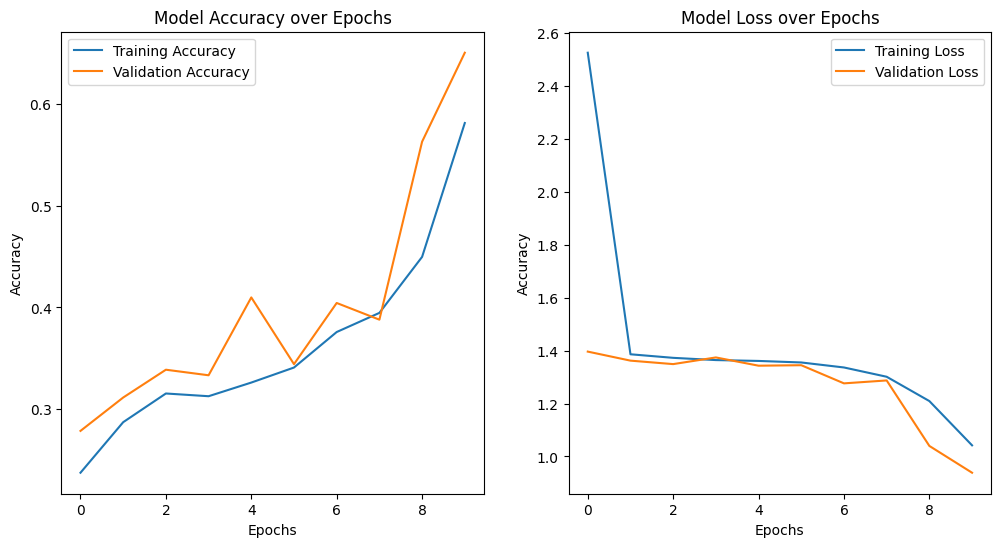

In [13]:
plot_hist(lenet)

# Alex Net

In [14]:
def alexnet_model(input_shape=(64, 64, 12), num_classes=4):
    model = models.Sequential()

    # Layer 1
    model.add(layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))

    # Layer 2
    model.add(layers.Conv2D(256, (5, 5), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))

    # Layer 3
    model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))

    # Layer 4
    model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))

    # Layer 5
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Global Average Pooling
    model.add(layers.GlobalAveragePooling2D())

    # Dense layers
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))

    # Output layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Create the AlexNet model
alex_net = alexnet_model(input_shape=input_shape, num_classes=num_classes)


# Compile the model with a specified learning rate
learning_rate = 0.001  # Set your desired learning rate
optimizer = Adam(learning_rate=learning_rate)
alex_net.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


alex_net.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 126, 96)      34944     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 62, 62, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 62, 62, 256)       614656    
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 30, 30, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 384)       885120    
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 384)      

In [16]:
# Train the model
epochs = 10

history = alex_net.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

# Save the trained model
alex_net_path = f'{model_save_dir}/alex_net_ecg_model.hd5'
alex_net.save(alex_net_path)

Epoch 1/10
24/24 [==============================] - 87s 4s/step - loss: 1.5234 - accuracy: 0.2792 - val_loss: 1.3717 - val_accuracy: 0.3060
Epoch 2/10
24/24 [==============================] - 80s 3s/step - loss: 1.3772 - accuracy: 0.2966 - val_loss: 1.3748 - val_accuracy: 0.3060
Epoch 3/10
24/24 [==============================] - 84s 4s/step - loss: 1.3768 - accuracy: 0.3047 - val_loss: 1.3713 - val_accuracy: 0.3060
Epoch 4/10
24/24 [==============================] - 78s 3s/step - loss: 1.3738 - accuracy: 0.3060 - val_loss: 1.3720 - val_accuracy: 0.3060
Epoch 5/10
24/24 [==============================] - 81s 3s/step - loss: 1.3743 - accuracy: 0.3060 - val_loss: 1.3714 - val_accuracy: 0.3060
Epoch 6/10
24/24 [==============================] - 77s 3s/step - loss: 1.3743 - accuracy: 0.3060 - val_loss: 1.3719 - val_accuracy: 0.3060
Epoch 7/10
24/24 [==============================] - 82s 3s/step - loss: 1.3752 - accuracy: 0.3060 - val_loss: 1.3713 - val_accuracy: 0.3060
Epoch 8/10
24/24 [==

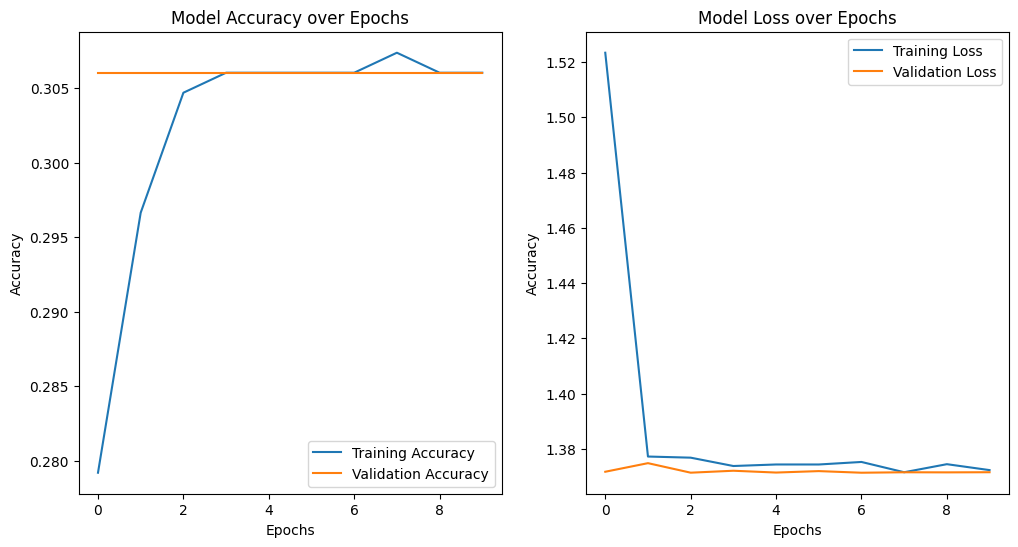

In [17]:
# Plotting accuracy history
plot_hist(alex_net)

## VGG-16

In [18]:
def vgg16_model(input_shape=(64, 64, 12), num_classes=4):
    model = models.Sequential()

    # Block 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    model.add(layers.Conv2D(96, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(96, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(96, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Flatten the output and add Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    # model.add(layers.Dropout(0.5))
    # model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))

    # Output layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Create the VGG16-like model
vgg16_net = vgg16_model(input_shape=input_shape, num_classes=num_classes)

# Compile the model
vgg16_net.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Print a summary of the model architecture
vgg16_net.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 512, 512, 32)      896       
                                                                 
 conv2d_8 (Conv2D)           (None, 512, 512, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 256, 256, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 256, 256, 64)      18496     
                                                                 
 conv2d_10 (Conv2D)          (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 128, 128, 64)      0         
 g2D)                                                 

In [19]:
# Train the model
epochs = 10

history = vgg16_net.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

# Save the trained model
vgg16_net_path = f'{model_save_dir}/vgg16_ecg_model.hd5'
vgg16_net.save(vgg16_net_path)

Epoch 1/10
24/24 [==============================] - 119s 4s/step - loss: 2.4853 - accuracy: 0.2711 - val_loss: 1.3745 - val_accuracy: 0.3060
Epoch 2/10
24/24 [==============================] - 87s 4s/step - loss: 1.3860 - accuracy: 0.2966 - val_loss: 1.3827 - val_accuracy: 0.3060
Epoch 3/10
24/24 [==============================] - 83s 3s/step - loss: 1.3855 - accuracy: 0.2617 - val_loss: 1.3819 - val_accuracy: 0.3060
Epoch 4/10
24/24 [==============================] - 83s 3s/step - loss: 1.3819 - accuracy: 0.2631 - val_loss: 1.3800 - val_accuracy: 0.3060
Epoch 5/10
24/24 [==============================] - 83s 3s/step - loss: 1.3809 - accuracy: 0.3034 - val_loss: 1.3787 - val_accuracy: 0.3060
Epoch 6/10
24/24 [==============================] - 85s 3s/step - loss: 1.3773 - accuracy: 0.3101 - val_loss: 1.3765 - val_accuracy: 0.3060
Epoch 7/10
24/24 [==============================] - 84s 4s/step - loss: 1.3757 - accuracy: 0.3047 - val_loss: 1.3750 - val_accuracy: 0.3060
Epoch 8/10
24/24 [=

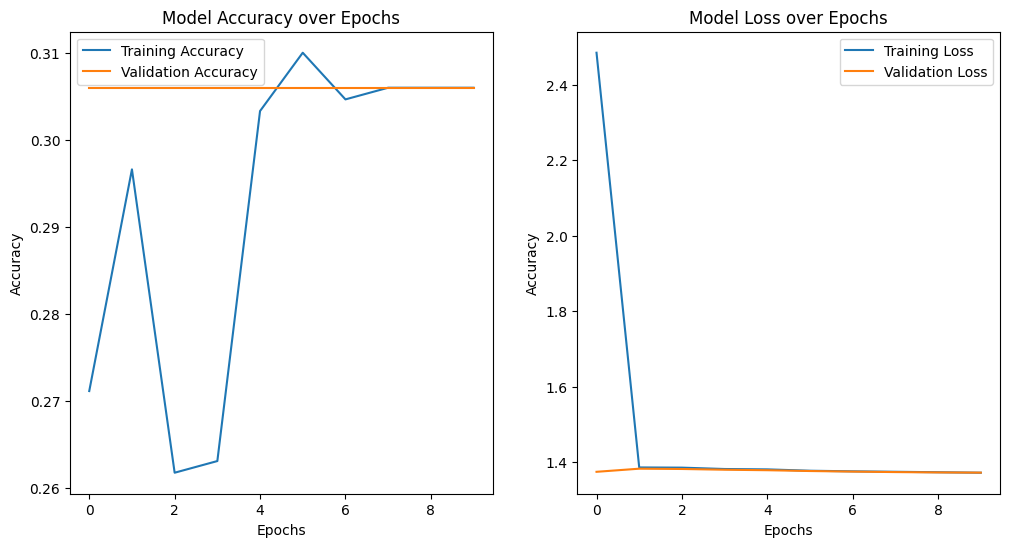

In [20]:
plot_hist(vgg16_net)

## GoogleNet

In [21]:
def inception_module(x, filters):
    # 1x1 Convolution
    conv1x1_1 = layers.Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    # 1x1 Convolution followed by 3x3 Convolution
    conv1x1_2 = layers.Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    conv3x3 = layers.Conv2D(filters[2], (3, 3), padding='same', activation='relu')(conv1x1_2)

    # 1x1 Convolution followed by 5x5 Convolution
    conv1x1_3 = layers.Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    conv5x5 = layers.Conv2D(filters[4], (5, 5), padding='same', activation='relu')(conv1x1_3)

    # 3x3 MaxPooling followed by 1x1 Convolution
    maxpool = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    conv1x1_4 = layers.Conv2D(filters[5], (1, 1), padding='same', activation='relu')(maxpool)

    # Concatenate the output of all branches
    inception = layers.concatenate([conv1x1_1, conv3x3, conv5x5, conv1x1_4], axis=-1)

    return inception

def googlenet_model(input_shape=(64, 64, 12), num_classes=4):
    input_layer = layers.Input(shape=input_shape)

    # Initial Convolutional Layer
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Inception Module 1
    x = inception_module(x, filters=[8, 32, 32, 8, 8, 8])

    # Inception Module 2
    x = inception_module(x, filters=[8, 32, 32, 8, 8, 8])

    # Flatten and Dense Layers
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # Output layer
    output_layer = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=input_layer, outputs=output_layer)

    return model

# Create the GoogLeNet-like model
googlenet = googlenet_model(input_shape=input_shape, num_classes=num_classes)

# Compile the model
googlenet.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

# Print a summary of the model architecture
googlenet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d_14 (Conv2D)          (None, 256, 256, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d_8 (MaxPoolin  (None, 128, 128, 64)         0         ['conv2d_14[0][0]']           
 g2D)                                                                                             
                                                                                                  
 conv2d_16 (Conv2D)          (None, 128, 128, 32)         2080      ['max_pooling2d_8[0][0]'] 

In [22]:
# Train the model
epochs = 10

history = googlenet.fit(
                          train_generator,
                          epochs=epochs,
                          validation_data=validation_generator
                      )

# Save the trained model
googlenet_path = f'{model_save_dir}/googlenet_ecg_model.hd5'
googlenet.save(googlenet_path)

Epoch 1/10
24/24 [==============================] - 91s 3s/step - loss: 7.8344 - accuracy: 0.2497 - val_loss: 1.3803 - val_accuracy: 0.3060
Epoch 2/10
24/24 [==============================] - 79s 3s/step - loss: 1.3869 - accuracy: 0.2604 - val_loss: 1.3855 - val_accuracy: 0.3060
Epoch 3/10
24/24 [==============================] - 84s 4s/step - loss: 1.3850 - accuracy: 0.3047 - val_loss: 1.3844 - val_accuracy: 0.3060
Epoch 4/10
24/24 [==============================] - 80s 3s/step - loss: 1.3871 - accuracy: 0.3060 - val_loss: 1.3840 - val_accuracy: 0.3060
Epoch 5/10
24/24 [==============================] - 85s 4s/step - loss: 1.3824 - accuracy: 0.2966 - val_loss: 1.3719 - val_accuracy: 0.3060
Epoch 6/10
24/24 [==============================] - 80s 3s/step - loss: 1.3773 - accuracy: 0.3060 - val_loss: 1.3752 - val_accuracy: 0.3115
Epoch 7/10
24/24 [==============================] - 83s 4s/step - loss: 1.3745 - accuracy: 0.3128 - val_loss: 1.3676 - val_accuracy: 0.3224
Epoch 8/10
24/24 [==

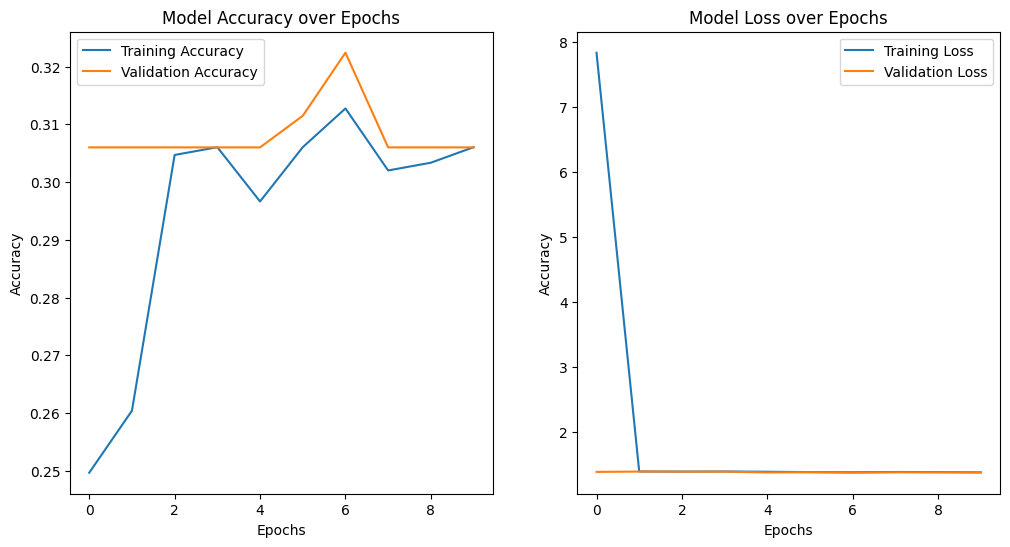

In [23]:
plot_hist(googlenet)

## ResNet50

In [24]:
from tensorflow.keras.applications import ResNet50

# Load the pre-trained ResNet50 model with weights from ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Create a custom head for your specific task
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(num_classes, activation='softmax')(x)

# Combine the base model with the custom head
resnet = models.Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
resnet.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

resnet.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 518, 518, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 256, 256, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 256, 256, 64)         256       ['conv1_conv[0][0]']          
 on)                       

In [25]:
# Train the model
epochs = 10
history = resnet.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

# Save the trained model
resnet_path = f'{model_save_dir}/resnet_ecg_model.hd5'

resnet.save(resnet_path)

Epoch 1/10
24/24 [==============================] - 104s 4s/step - loss: 2.8910 - accuracy: 0.2738 - val_loss: 1.6440 - val_accuracy: 0.2568
Epoch 2/10
24/24 [==============================] - 84s 4s/step - loss: 1.8365 - accuracy: 0.2832 - val_loss: 1.3919 - val_accuracy: 0.2951
Epoch 3/10
24/24 [==============================] - 82s 3s/step - loss: 1.4180 - accuracy: 0.3450 - val_loss: 1.3250 - val_accuracy: 0.3115
Epoch 4/10
24/24 [==============================] - 84s 3s/step - loss: 1.3408 - accuracy: 0.3745 - val_loss: 1.2702 - val_accuracy: 0.4863
Epoch 5/10
24/24 [==============================] - 88s 4s/step - loss: 1.3189 - accuracy: 0.3597 - val_loss: 1.3031 - val_accuracy: 0.4317
Epoch 6/10
24/24 [==============================] - 85s 4s/step - loss: 1.3453 - accuracy: 0.3812 - val_loss: 1.3019 - val_accuracy: 0.3388
Epoch 7/10
24/24 [==============================] - 82s 3s/step - loss: 1.3147 - accuracy: 0.3893 - val_loss: 1.2807 - val_accuracy: 0.3989
Epoch 8/10
24/24 [=

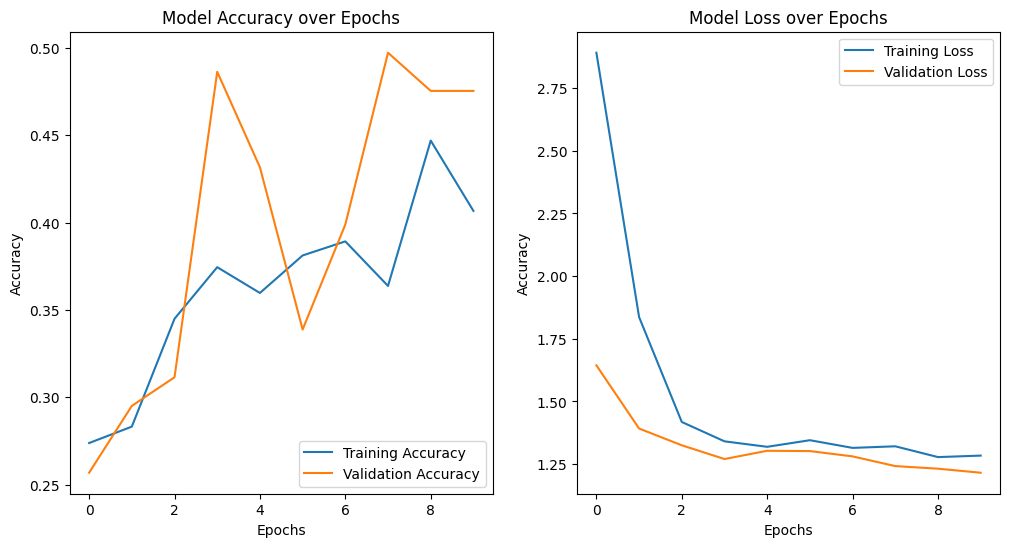

In [26]:
plot_hist(resnet)

## Models performance comparison

In [6]:
lenet_path = f'{model_save_dir}/lenet5_ecg_model.keras'
alex_net_path = f'{model_save_dir}/alex_net_ecg_model.keras'
vgg16_net_path = f'{model_save_dir}/vgg16_ecg_model.keras'
googlenet_path = f'{model_save_dir}/googlenet_ecg_model.keras'
resnet_path = f'{model_save_dir}/resnet_ecg_model.keras'


#Loading Models:
lenet = tf.keras.saving.load_model(lenet_path)
alex_net = tf.keras.saving.load_model(alex_net_path)
vgg16_net = tf.keras.saving.load_model(vgg16_net_path)
googlenet = tf.keras.saving.load_model(googlenet_path)
resnet = tf.keras.saving.load_model(resnet_path)

ValueError: ignored

=================================== Evaluation for LeNet ===================================
6/6 [==============================] - 17s 3s/step
Classification Report:
                       precision    recall  f1-score   support

        History of MI       0.20      0.12      0.15        34
Myocardial Infarction       0.36      0.47      0.41        47
               Normal       0.30      0.43      0.35        56
   abnormal heartbeat       0.14      0.07      0.09        46

             accuracy                           0.29       183
            macro avg       0.25      0.27      0.25       183
         weighted avg       0.26      0.29      0.26       183



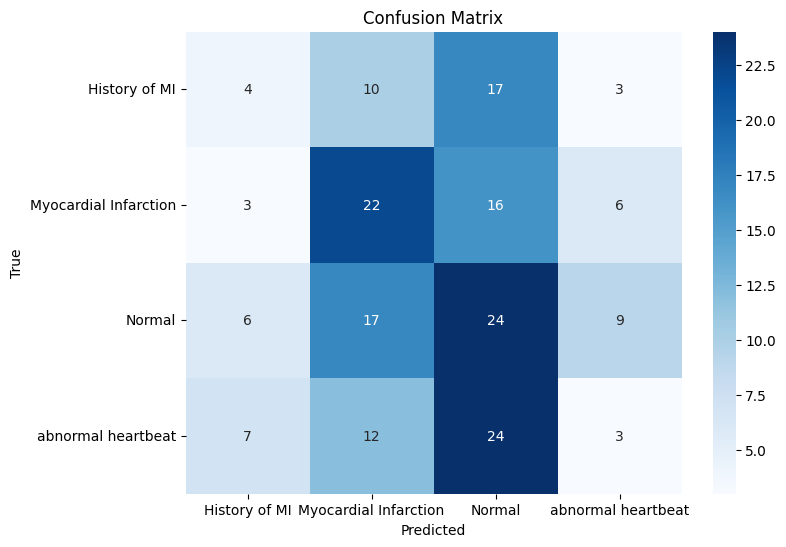




=================================== Evaluation for Alex Net ===================================
6/6 [==============================] - 19s 3s/step
Classification Report:
                       precision    recall  f1-score   support

        History of MI       0.00      0.00      0.00        34
Myocardial Infarction       0.00      0.00      0.00        47
               Normal       0.31      1.00      0.47        56
   abnormal heartbeat       0.00      0.00      0.00        46

             accuracy                           0.31       183
            macro avg       0.08      0.25      0.12       183
         weighted avg       0.09      0.31      0.14       183



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


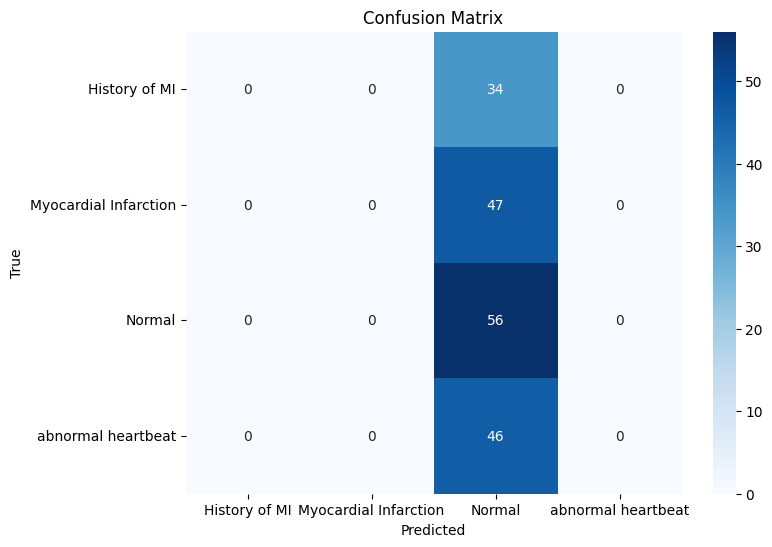




=================================== Evaluation for VGG-16 ===================================
6/6 [==============================] - 16s 3s/step
Classification Report:
                       precision    recall  f1-score   support

        History of MI       0.00      0.00      0.00        34
Myocardial Infarction       0.00      0.00      0.00        47
               Normal       0.31      1.00      0.47        56
   abnormal heartbeat       0.00      0.00      0.00        46

             accuracy                           0.31       183
            macro avg       0.08      0.25      0.12       183
         weighted avg       0.09      0.31      0.14       183



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


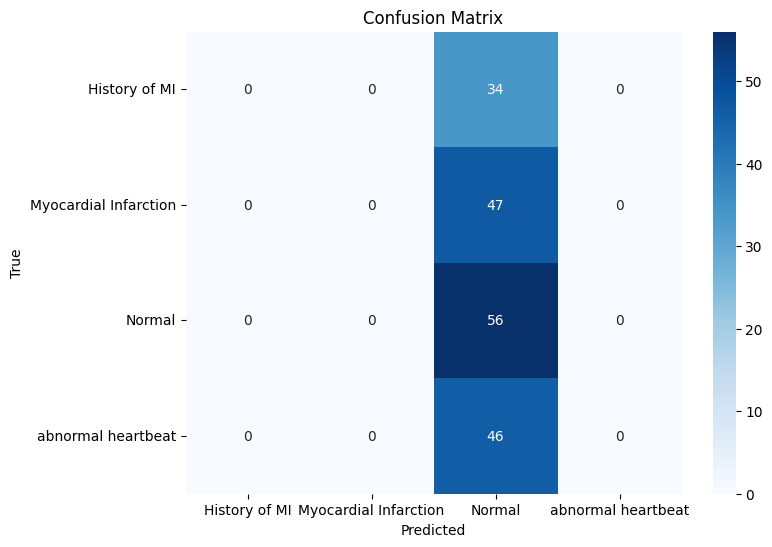




=================================== Evaluation for GoogleNet ===================================
6/6 [==============================] - 16s 2s/step
Classification Report:
                       precision    recall  f1-score   support

        History of MI       0.00      0.00      0.00        34
Myocardial Infarction       0.00      0.00      0.00        47
               Normal       0.30      0.96      0.46        56
   abnormal heartbeat       0.00      0.00      0.00        46

             accuracy                           0.30       183
            macro avg       0.07      0.24      0.11       183
         weighted avg       0.09      0.30      0.14       183



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


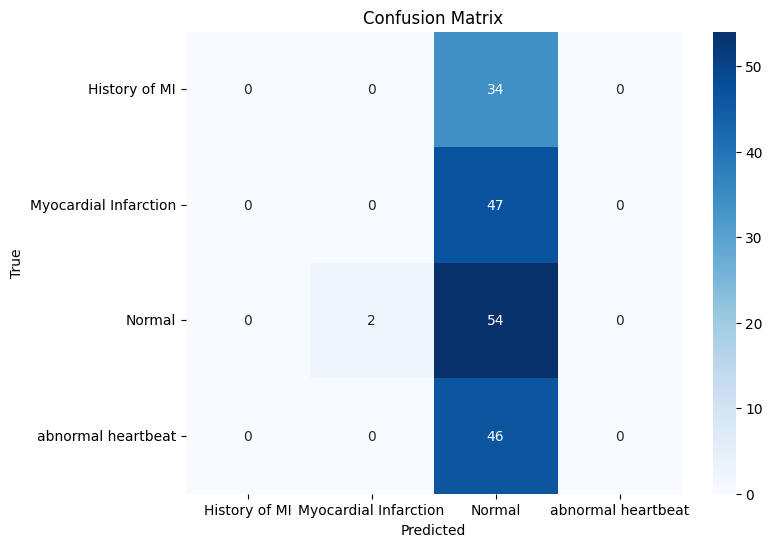




=================================== Evaluation for ResNet ===================================
6/6 [==============================] - 17s 3s/step
Classification Report:
                       precision    recall  f1-score   support

        History of MI       0.00      0.00      0.00        34
Myocardial Infarction       0.33      0.02      0.04        47
               Normal       0.32      0.57      0.41        56
   abnormal heartbeat       0.31      0.54      0.40        46

             accuracy                           0.32       183
            macro avg       0.24      0.28      0.21       183
         weighted avg       0.26      0.32      0.24       183



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


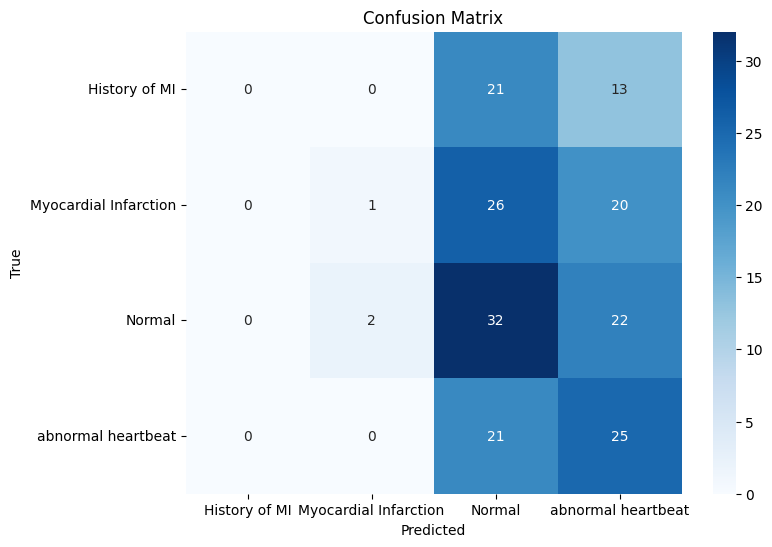

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Function to print evaluation metrics and plot confusion matrix heatmap
def print_evaluation(model, generator, model_name):
    print(f"=================================== Evaluation for {model_name} ===================================")
    y_true = generator.classes
    class_labels = list(generator.class_indices.keys())

    # Get predictions from the model
    y_pred_prob = model.predict(generator)
    y_pred = np.argmax(y_pred_prob, axis=1)


    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    # Create confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Plotting confusion matrix heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print("\n\n")

# Print evaluation for each model

models = {"LeNet": lenet, "Alex Net": alex_net, "VGG-16": vgg16_net, "GoogleNet": googlenet, "ResNet": resnet}

for model_name, model in models.items():
    print_evaluation(model, validation_generator, model_name)